# Multimodal GraphRAG | mmGraphRAG
This notebook demonstrates the mmGraphRAG system for multimodal retrieval augmented generation.
It presents the initial mmGraphRAG steps and establishes associative search only. 
These steps include the processesing images using CLIP embeddings and BAML for captioning, then visualizes the results
in TensorBoard. The system combines computer vision and natural language processing to enable
semantic search and analysis across image and text modalities. Additionally, the notebook introduces using BAML to decompose
images into features and objects for image graph generation which will be covered more in ODSC Boston.

We will use ten images from the [COCO](https://cocodataset.org/#home) dataset to demonstrate semantic embedding. We have selected five images that contain `bananas` and five images that contain `elephants` to demo semantic separation. The value of mmGraphRAG is in discovering the nuance in semantically similar embeddings.

## Notebook Objectives
- Demonstrate how to achieve Associative Search
- Provide knowledge and code building blocks for Associative Search
- Reveal insights into image decomposition and ongoing work in mmGraphRAG

In [1]:
# Standard library imports
import os
import sys
import json

In [2]:
# Third party imports
import tqdm
import numpy as np

In [3]:
# Local imports
from mmgraphrag_odsc_west_2025.config import config
from mmgraphrag_odsc_west_2025.lib.image_processing import ImageProcessing
from mmgraphrag_odsc_west_2025.lib.audio_processing import AudioProcessing
from mmgraphrag_odsc_west_2025.lib.embedding import SemanticEmbeddings
from mmgraphrag_odsc_west_2025.utils.logger import setup_logger

In [5]:
# Configure logging
log = setup_logger(__name__)

## What is BAML and why are we using it?
BAML (Basically, A Made-Up Language) is a domain-specific language designed specifically for building LLM prompts as functions. BAML is the foundation for how we will build our agentic workflows in upcoming presentations. It offers several key advantages that make it stand out from other LLM frameworks.

Developers should consider BAML when they need a robust, type-safe way to work with LLMs in production applications, especially when dealing with structured outputs or building complex AI agents. It's particularly valuable for teams that want to maintain clean separation between prompt engineering and application logic while ensuring type safety across their LLM operations.

In [ ]:
# Set BAML Logging [error, warn, info, debug, trace, off]
# This should be set before importing BAML
os.environ["BAML_LOG"] = config.BAML_LOG

# Verify it's set
log.info(os.getenv("BAML_LOG"))

In [7]:
# Setup autoreload extension for BAML
%load_ext autoreload
%autoreload 2

### Local library functionality
We imported functionality from classes and other files included in this project repository. We will briefly look at some of that code during the presentation.

In [30]:
# Instantiate ImageProcessing and SemanticEmbedding
imaging = ImageProcessing()
embedding = SemanticEmbeddings()
acoustics = AudioProcessing()

In [31]:
# BAML sepecific imports
import mmgraphrag_odsc_west_2025.baml_client as baml

## Embeddings for Associative Search
We are going to use [CLIP](https://openai.com/index/clip/) from OpenAI to create a combined embedding of an image and its caption which will enable our objective of achieving associative search through semantic embeddings. CLIP is neural network which efficiently learns visual concepts from natural language supervision. We will use it to demonstrate how to encode image semantics in a 512 dimensional embedding space.

### Step One
Let's take a look at a sample image

In [32]:
image_path = os.path.join("../", "images/b_COCO_val2014_000000001153.jpg")

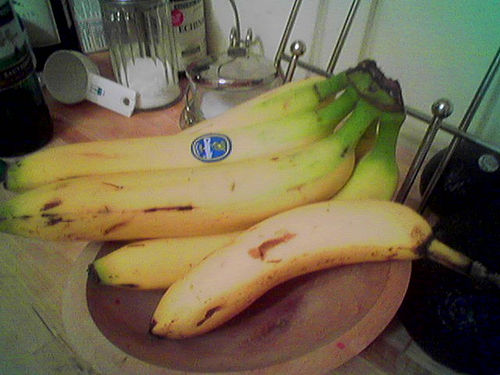

In [33]:
# Lets take a look at the image
image = imaging.open(image_path)
display(image)

### Embeddings Step Two
We first need to prepare our image of bananas to be used with BAML and language models. Most language model APIs require a [Base64](https://en.wikipedia.org/wiki/Base64) endcoding of images or audio. Base64 is a binary-to-text encoding scheme that encodes binaries into printable alphanumeric characters.

In [34]:
# Test loading an image and converting it to Base64
image_base64 = imaging.image_to_base64(image_path)

In [35]:
# Let's see what the Base64 version of these bananas looks like. We will look at just the first 100 characters.
first_100_chars = image_base64[:100]
print(first_100_chars)

/9j/4AAQSkZJRgABAQEASABIAAD/2wBDAAYEBQYFBAYGBQYHBwYIChAKCgkJChQODwwQFxQYGBcUFhYaHSUfGhsjHBYWICwgIyYn


In [14]:
# Construct a BAML Image Object
img = {
    "base64":image_base64,
    "media_type": "image/png"
}

### A simpler approach to passing multimedia parameters to BAML if not using an API
```python
from baml_py import Image
img = Image.from_base64("image/png", image_b64)
```

### Step Three
Now that we have our Base64 encoding for our image of bananas, we need to generate the second parameter of our CLIP embedding function, we need a caption. Since our image does not have a caption (COCO does supply annotations but we are not using them in this project) we need to create one. This is where BAML comes in. Our BAML data types and functions provide a an AI language for deterministic outputs and here we will leverage that capability to generate captions. Let's briefly look at the baml_src folder to see what captions.baml looks like inside our code editor.

We will use BAML functionality and the vision model [LLaVA](https://llava-vl.github.io/) to generate captions.

In [36]:
# Generate a caption for the image
response = baml.b.ExtractImageCaption(img)
caption = response.caption
print(caption)

A bunch of bananas sitting in a bowl on a bathroom counter.


### Step Four
We now have all the required components to complete the generation of a semantic embedding for our associative search. Let's pass both the image Base64 encoding and the caption we just generated with BAML to our CLIP embedding function.

In [16]:
# Now lets embedd the image and caption using CLIP
image_embedding = embedding.get_clip_embedding(image_path, caption)
log.info(f"Embedding Length: {len(image_embedding)}")
assert len(image_embedding) == 512, "Not a valid CLIP dimension"

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


2025-10-28 06:28:14,215 - __main__ - INFO - Embedding Length: 512


## Embedding Review
__Congratulations!__ We now have the foundations for creating semantic embeddings. We need to use this knowledge to process all of our images to acheive our objective associative search in an embedding space. We will now process all the images in our image directory using the process we just learned. As a bonus, this function not only creates our embeddings, it also creates file artifacts so that we can view our embedding space. It even creates a collection of our images as sprites for some visual fun when we look at this space in our upcoming steps.

In [17]:
# Process all the images in our image directory. Since this function normally takes just a sample we will pass the number 10 as our second argument
# since that is the total number of images in our directory. We could rewrite this function to create a list of all files and process them or create
# another function which processes all files in a directory. 
results = imaging.process_images("../images", 10)
log.info(f"Results: {results}")

2025-10-23 06:59:14,620 - mmgraphrag_odsc_west_2025.lib.image_processing - INFO - TensorBoard directory ready at /Users/davidhughes/dev/mmgraphrag-odsc-west-2025/src/mmgraphrag_odsc_west_2025/tensorboard


Processing images: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.52s/it]

2025-10-23 06:59:59,842 - mmgraphrag_odsc_west_2025.lib.image_processing - INFO - Wrote 10 vectors out of 10 successful entries
2025-10-23 06:59:59,869 - __main__ - INFO - Results: 10



2025-10-23 06:59:59.853878: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


## Visualization of our Embeddging Space
Now that we have the embeddings for our images let's take a look at them. We can do this using [Tensorboard](https://www.tensorflow.org/tensorboard) which we will embedd, no pun intended, into this Jupyter notebook.

In [17]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [18]:
# Start TensorBoard and point it to your log directory
%tensorboard --logdir ../tensorboard

## Where do we go from here?
In the the demo above we created a semantic embedding space using CLIP embeddings of images and captions. The embedding space enabled associative search. Now we want to think about how can we decompose our images into component features and create an Image Graph for a higher fidelity search and semantic reasoning of results. Our first task will be to decompose images so that we can model them as a graph. Using our BAML approach to AI programming and a vision model, we can explore how we might proceed.

In [19]:
# Extract the image's features
response = baml.b.ExtractImageFeatures(img)
features = {
    "colors":response.colors,
    "sharpnes":response.sharpness,
    "complexity":response.complexity
}
print(json.dumps(features, indent=4))

{
    "colors": [
        "yellow",
        "green",
        "brown"
    ],
    "sharpnes": "moderate",
    "complexity": "low"
}


In [20]:
# Extract objects found in the image
response = baml.b.ExtractImageObjects(img)
objects = [{
    "name":object.name,
    "colors":[object.colors],
    "bounding_box":object.bounding_box
} for object in response]
print(json.dumps(objects, indent=4))

[
    {
        "name": "Bananas",
        "colors": [
            [
                "yellow",
                "green"
            ]
        ],
        "bounding_box": [
            0.264,
            0.378,
            0.591,
            0.869
        ]
    }
]


In [21]:
# Let's put it all together
response = baml.b.AnalyzeImage(img)
analysis = {
    "caption":response.description.caption,
    "features":{"colors":response.features.colors,"sharpnes":response.features.sharpness,"complexity":response.features.complexity},
    "objects":[{"name":object.name,"colors":[object.colors],"bounding_box":object.bounding_box} for object in response.objects]
}
print(json.dumps(analysis, indent=4))

{
    "caption": "Bunch of bananas on a plate",
    "features": {
        "colors": [
            "yellow",
            "green",
            "brown"
        ],
        "sharpnes": "high",
        "complexity": "low"
    },
    "objects": [
        {
            "name": "bananas",
            "colors": [
                [
                    "yellow",
                    "green"
                ]
            ],
            "bounding_box": [
                0.264,
                0.378,
                0.591,
                0.767
            ]
        }
    ]
}


## What About Audio?
Let's explore audio analysis using BAML. We will not show embedding approaches for audio (they do exist); instead, we will demonstrate LM audio analysis.

### Step One
We will start by listening to a sample audio

In [22]:
audio_path = os.path.join("../", "audio/police_cars.mp3")

In [23]:
# Let's listen to a sample of the audio
audio_data, sample_rate = acoustics.open(audio_path)

# Display audio information
print(f"Audio duration: {len(audio_data) / sample_rate:.2f} seconds")
print(f"Sample rate: {sample_rate} Hz")
print(f"Audio shape: {audio_data.shape}")

# Take only the first 8 seconds for playback
sample_duration = 8  # seconds
sample_samples = int(sample_rate * sample_duration)
audio_sample = audio_data[:sample_samples]

print(f"Playing first {sample_duration} seconds of audio")

# For playback, convert to mono to avoid WAV format issues
# But keep the full stereo data for BAML analysis
if len(audio_sample.shape) == 2:
    # Convert stereo to mono by averaging channels
    audio_mono = np.mean(audio_sample, axis=1)
    print(f"Converted to mono for playback. Original stereo shape: {audio_sample.shape}")
else:
    audio_mono = audio_sample

# Ensure proper format for IPython Audio
if audio_mono.dtype != np.float32:
    audio_mono = audio_mono.astype(np.float32)

# Normalize if needed
max_val = np.max(np.abs(audio_mono))
if max_val > 1.0:
    audio_mono = audio_mono / max_val

print(f"Playback sample shape: {audio_mono.shape}")
print(f"Full audio data preserved for analysis: {audio_data.shape}")

# Play the audio sample (mono for playback)
from IPython.display import Audio
Audio(audio_mono, rate=sample_rate)


Audio duration: 22.15 seconds
Sample rate: 24000 Hz
Audio shape: (531648, 2)
Playing first 8 seconds of audio
Converted to mono for playback. Original stereo shape: (192000, 2)
Playback sample shape: (192000,)
Full audio data preserved for analysis: (531648, 2)


### Audio Analysis Step Two
We first need to prepare our audio file to be used with BAML and language models. Most language model APIs require a [Base64](https://en.wikipedia.org/wiki/Base64) encoding of images or audio. Base64 is a binary-to-text encoding scheme that encodes binaries into printable alphanumeric characters.

In [24]:
# Test loading an audio file and converting it to Base64
audio_base64 = acoustics.audio_to_base64(audio_path)

In [25]:
# Let's see what the Base64 version of this audio looks like. We will look at just the first 100 characters.
first_100_chars = audio_base64[:100]
print(first_100_chars)

//PkZAAhFgkEAa1gAJ1JUhgBWHgAKaEqXSMswOFOOpUOZCNokBSRBGZQsZQYhYFwZiyJkyJjxJdN6gSBMKFMKFBQNq6AgwQQOACM


In [26]:
# Construct a BAML Audio Object
audio_obj = {
    "base64": audio_base64,
    "media_type": "audio/mp3"
}

### Step Three
Now that we have our Base64 encoding for our audio file, we can analyze it using BAML. Our BAML data types and functions provide an AI language for deterministic outputs and here we will leverage that capability to generate audio analysis. Let's look at the av_spatiotemporal.baml file to see what audio analysis functions are available.

We will use BAML functionality and audio models to analyze the audio content.

In [27]:
# Analyze the audio using BAML
response = baml.b.AnalyzeAudio(audio_obj)

# Convert AudioObject instances to dictionaries for JSON serialization
audio_objects_dict = []
for obj in response.audio_objects:
    audio_objects_dict.append({
        "name": obj.name,
        "start_time": obj.start_time,
        "duration": obj.duration,
        "location": obj.location,
        "travel_of_direction": obj.travel_of_direction,
        "speed": obj.speed,
        "explanation": obj.explanation
    })

analysis = {
    "audio_objects": audio_objects_dict,
    "temporal_relationships": response.temporal_relationships
}

print("Audio Analysis:")
print(json.dumps(analysis, indent=4))

Audio Analysis:
{
    "audio_objects": [
        {
            "name": "siren",
            "start_time": 0.0,
            "duration": 9.0,
            "location": "center",
            "travel_of_direction": "going right",
            "speed": 20.0,
            "explanation": "The sound is a continuous wailing siren, typically associated with emergency vehicles like police cars, ambulances, or fire trucks. The pitch and volume change over time, indicating the Doppler effect, which suggests the vehicle is moving from left to right and passing by the listener."
        }
    ],
    "temporal_relationships": [
        "The siren starts at the beginning of the audio and gradually increases in volume, then decreases as it moves past, indicating the vehicle is approaching and then moving away."
    ]
}
